In [1]:
import pandas as pd
import re
import time
import datetime

In [2]:
import plots.e2e_parse_benchlog as parser
import os

e2e_base_dir = "/Users/hidde/PhD/fl/fl-ansible/experiment_results/e2e/"

configs = {
    # CIFAR Large
    os.path.join(e2e_base_dir, "1621422555/0"): {
        "dataset": "CIFAR Large",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 102.76
    },
    os.path.join(e2e_base_dir, "1621422555/1"): {
        "dataset": "CIFAR Large",
        "type": "plain",
        "version": "None",
        "bandwidth": 4.19
    },

    # CIFAR Small
    # os.path.join(e2e_base_dir, "cifar_small_1622012533/0"): {
    #     "dataset": "CIFAR Small",
    #     "type": "l2_opt",
    #     "version": "optimized"
    # },
    # os.path.join(e2e_base_dir, "cifar_small_1622012533/1"): {
    #     "dataset": "CIFAR Small",
    #     "type": "l2",
    #     "version": "unoptimized"
    # },
    # os.path.join(e2e_base_dir, "1621432136/0"): {
    #     "dataset": "CIFAR Small",
    #     "type": "linf_opt",
    #     "version": "optimized"
    # },
    # os.path.join(e2e_base_dir, "1621432136/1"): {
    #     "dataset": "CIFAR Small",
    #     "type": "linf",
    #     "version": "unoptimized"
    # },
    # os.path.join(e2e_base_dir, "1621432136/2"): {
    #     "dataset": "CIFAR Small",
    #     "type": "plain",
    #     "version": None
    # },
    os.path.join(e2e_base_dir, "cifar_small_1622893559/0"): {
        "dataset": "CIFAR Small",
        "type": "l2_opt",
        "version": "optimized",
        "bandwidth": 6.73
    },
    os.path.join(e2e_base_dir, "cifar_small_1622893559/1"): {
        "dataset": "CIFAR Small",
        "type": "l2",
        "version": "unoptimized",
        "bandwidth": 34.77
    },
    os.path.join(e2e_base_dir, "cifar_small_1622893559/2"): {
        "dataset": "CIFAR Small",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 23.34
    },
    os.path.join(e2e_base_dir, "cifar_small_1622893559/3"): {
        "dataset": "CIFAR Small",
        "type": "linf",
        "version": "unoptimized",
        "bandwidth": 23.34
    },
    os.path.join(e2e_base_dir, "cifar_small_1622893559/4"): {
        "dataset": "CIFAR Small",
        "type": "plain",
        "version": None,
        "bandwidth": 0.95
    },

    # CIFAR Small L2
    # MNIST Linf, L2
    os.path.join(e2e_base_dir, "mnist_e2e_1622794982/0"): {
        "dataset": "MNIST",
        "type": "l2_opt",
        "version": "optimized",
        "bandwidth": 2.81
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1622794982/1"): {
        "dataset": "MNIST",
        "type": "l2",
        "version": "unoptimized",
        "bandwidth": 10.75
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1622794982/2"): {
        "dataset": "MNIST",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 7.21
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1622794982/3"): {
        "dataset": "MNIST",
        "type": "linf",
        "version": "unoptimized",
        "bandwidth": 7.21
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1622794982/4"): {
        "dataset": "MNIST",
        "type": "plain",
        "version": None,
        "bandwidth": 0.29
    }
}

,time,round,loss,acc,idf,dataset,type,version,bandwidth,rel_time
0,2021-05-19 11:21:49.909,1,2.238304,0.2583,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,NaN
1,2021-05-19 11:23:39.594,2,2.090126,0.2530,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,109.685
2,2021-05-19 11:25:45.538,3,2.111661,0.2526,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,125.944
3,2021-05-19 11:28:01.014,4,2.148866,0.2704,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,135.476
4,2021-05-19 11:30:14.570,5,2.132672,0.2897,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,133.556
5,2021-05-19 11:32:16.602,6,1.977730,0.3465,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,122.032
6,2021-05-19 11:34:36.318,7,1.808787,0.3979,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,139.716
7,2021-05-19 11:36:46.898,8,1.663858,0.4425,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,130.580
8,2021-05-19 11:38:54.907,9,1.567876,0.4790,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,128.009
9,2021-05-19 11:41:10.762,10,1.531280,0.4930,CIFAR Large linf_opt optimized,CIFAR Large,linf_opt,optimized,102.76,135.855


idf
CIFAR Large linf_opt optimized    130.735711
CIFAR Large plain None             20.971711
CIFAR Small l2_opt optimized       52.876000
CIFAR Small l2 unoptimized        281.909316
CIFAR Small linf_opt optimized     38.217026
CIFAR Small linf unoptimized      251.674158
CIFAR Small plain None              2.105278
MNIST l2_opt optimized             26.019949
MNIST l2 unoptimized              132.016077
MNIST linf_opt optimized           19.632641
MNIST linf unoptimized            123.719513
MNIST plain None                    3.371103
Name: rel_time, dtype: float64

idf
CIFAR Large linf_opt optimized    259.799846
CIFAR Large plain None             21.039250
CIFAR Small l2_opt optimized      106.015821
CIFAR Small l2 unoptimized        281.944150
CIFAR Small linf_opt optimized     75.889462
CIFAR Small linf unoptimized      252.239075
CIFAR Small plain None              2.125825
MNIST l2_opt optimized             52.074231
MNIST l2 unoptimized              131.843875
MNIST linf_opt optimized           39.293231
MNIST linf unoptimized            123.656550
MNIST plain None                    3.372950
Name: verification_complete, dtype: float64

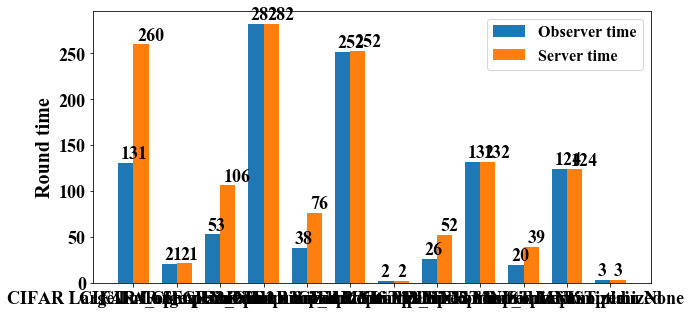

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [f"{config['dataset']} {config['type']} {config['version']}" for _, config in configs.items()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

data_server, observer_data = pd.DataFrame(), pd.DataFrame()
for i, (path, config) in enumerate(configs.items()):
    s, o = parser.load_benchlog(path)

    for v in [s, o]:
        idf = f"{config['dataset']} {config['type']} {config['version']}"
        v["idf"] = idf
        for key in ['dataset', 'type', 'version', 'bandwidth']:
            v[key] = config[key]

    o["rel_time"] = o['time'].diff().dt.total_seconds()
    o["rel_time"] = o["rel_time"][1:]

    data_server = data_server.append(s)
    observer_data = observer_data.append(o)

# display(observer_data)
pd.set_option('display.max_rows', 500)

fig, ax = plt.subplots(figsize=[10, 5])

# x = observer_data.groupby(["idf"])["time"].diff().dt.total_seconds()

# observer_data["rel_time"] = observer_data['time'].diff().dt.total_seconds()
# observer_data[observer_data["round"] == 0]["rel_time"] = None

display(observer_data)
# display(observer_data.groupby(["idf"])["rel_time"].mean())

y1 = observer_data.groupby(["idf"], sort=False)["rel_time"].mean()
y2 = data_server.groupby(["idf"], sort=False)["verification_complete"].mean() / 1000
rects1 = ax.bar(x - width/2, y1, width, label='Observer time')
rects2 = ax.bar(x + width/2, y2, width, label='Server time')

display(y1)
display(y2)

ax.set_ylabel("Round time")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
for a, (b, c) in zip(x, zip(y1, y2)):
    ax.text(a - width / 1.2, b + 5, round(b), color='black')
    ax.text(a + width / 4, c + 5, round(c), color='black')

# plt.show()
plt.savefig("plots_output/e2e_cifar_linf.png")

# data_server.to_csv("")

In [4]:
# Server benchlor

results = data_server.groupby(["dataset", "type"]).agg({'verification_complete': ['sum', 'mean', 'sem']})
results.reset_index()
results_per_dataset = results.groupby("dataset")
# print(results_per_dataset)

in_group = results['verification_complete']['mean']\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
# results['fraction'] = results['verification_complete']['mean'] / results[results['type'] == 'plain']['verification_complete']['mean']

in_group = in_group.rename('mean_factor')

results = results.join(in_group, on=['dataset', 'type'])
results['mean_factor'] = results['mean_factor'].round(2)
display(results)

/Users/hidde/opt/anaconda3/envs/tf37_standard/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(verification_complete, sum)  \
dataset     type                                     
CIFAR Large linf_opt                      10132194   
            plain                           841570   
CIFAR Small l2                            11277766   
            l2_opt                         4134617   
            linf                          10089563   
            linf_opt                       2959689   
            plain                            85033   
MNIST       l2                             5273755   
            l2_opt                         2030895   
            linf                           4946262   
            linf_opt                       1532436   
            plain                           134918   

                      (verification_complete, mean)  \
dataset     type                                      
CIFAR Large linf_opt                  259799.846154   
            plain                      21039.250000   
CIFAR Small l2                        281944.150000   
            l2_opt                    106015.820513   
            linf                      252239.075000   
            linf_opt                   75889.461538   
            plain                       2125.825000   
MNIST       l2                        131843.875000   
            l2_opt                     52074.230769   
            linf                      123656.550000   
            linf_opt                   39293.230769   
            plain                       3372.950000   

                      (verification_complete, sem)  mean_factor  
dataset     type                                                 
CIFAR Large linf_opt                   1798.932349        12.35  
            plain                        53.909810         1.00  
CIFAR Small l2                         1259.684520       132.63  
            l2_opt                      856.505020        49.87  
            linf                       1031.848863       118.65  
            linf_opt                    575.838463        35.70  
            plain                        18.198686         1.00  
MNIST       l2                          665.605279        39.09  
            l2_opt                      365.720588        15.44  
            linf                        725.597482        36.66  
            linf_opt                    294.451595        11.65  
            plain                        13.169504         1.00

In [5]:
observer_results = observer_data.groupby(["dataset", "type"]).agg({'rel_time': ['sum', 'mean', 'sem'], 'acc': lambda x: x.iloc[-1], 'loss': ['min'], 'bandwidth': 'mean'})
in_group = observer_results['rel_time']['mean']\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
in_group = in_group.rename('mean_factor')
observer_results = observer_results.join(in_group, on=['dataset', 'type'])
observer_results['mean_factor'] = observer_results["mean_factor"].round(2)

in_group = observer_results[('bandwidth', 'mean')]\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
in_group = in_group.rename('bw_factor')
observer_results = observer_results.join(in_group, on=['dataset', 'type'])
observer_results['bw_factor'] = observer_results["bw_factor"].round(0)

display(observer_results)

(rel_time, sum)  (rel_time, mean)  (rel_time, sem)  \
dataset     type                                                           
CIFAR Large linf_opt         4967.957        130.735711         0.838520   
            plain             796.925         20.971711         0.018137   
CIFAR Small l2              10712.554        281.909316         1.211833   
            l2_opt           2062.164         52.876000         0.516298   
            linf             9563.618        251.674158         0.890499   
            linf_opt         1452.247         38.217026         0.297423   
            plain              75.790          2.105278         0.005785   
MNIST       l2               5148.627        132.016077         0.657625   
            l2_opt           1014.778         26.019949         0.225743   
            linf             4825.061        123.719513         0.740639   
            linf_opt          765.673         19.632641         0.302457   
            plain             131.473          3.371103         0.011168   

                      (acc, <lambda>)  (loss, min)  (bandwidth, mean)  \
dataset     type                                                        
CIFAR Large linf_opt           0.6534     1.167348             102.76   
            plain              0.6644     1.111817               4.19   
CIFAR Small l2                 0.5415     1.312159              34.77   
            l2_opt             0.5429     1.282517               6.73   
            linf               0.5410     1.319909              23.34   
            linf_opt           0.5352     1.338452              23.34   
            plain              0.5384     1.329768               0.95   
MNIST       l2                 0.9744     0.134064              10.75   
            l2_opt             0.9713     0.145796               2.81   
            linf               0.9737     0.126002               7.21   
            linf_opt           0.9742     0.122607               7.21   
            plain              0.9747     0.121824               0.29   

                      mean_factor  bw_factor  
dataset     type                              
CIFAR Large linf_opt         6.23       25.0  
            plain            1.00        1.0  
CIFAR Small l2             133.91       37.0  
            l2_opt          25.12        7.0  
            linf           119.54       25.0  
            linf_opt        18.15       25.0  
            plain            1.00        1.0  
MNIST       l2              39.16       37.0  
            l2_opt           7.72       10.0  
            linf            36.70       25.0  
            linf_opt         5.82       25.0  
            plain            1.00        1.0

In [6]:

# output
cols = [('acc', '<lambda>'), ('rel_time', 'mean'), ('rel_time', 'sum'), ('bandwidth', 'mean'), 'mean_factor', 'bw_factor']

output_frame = pd.DataFrame()
output_frame[['acc', 'mean_s', 'sum_s', 'bandwidth_GB', 'mean_factor', 'bw_factor']] = observer_results[cols]
output_frame['mean_factor'] = output_frame['mean_factor'].round(0).astype(np.int32)
output_frame['bw_factor'] = output_frame['bw_factor'].round(0).astype(np.int32)

# Server terminates at round id 39.
output_frame['sum_s'] = output_frame['sum_s'] + output_frame['mean_s']


# output_frame['acc'] = output_frame['acc'].round(2)
# output_frame['mean'] = (output_frame['mean']).combine(output_frame['mean_factor'], lambda x, y: str(round(x)) + 's (' + str(y) + 'x)'
#                                                                                 if y > 1.0 else
#                                                                                str(round(x)) + 's')


                           # .round(0).astype(np.int32).astype(str) + 's (' + output_frame['mean_factor'].astype(str) + 'x)'

# output_frame['total'] = output_frame['sum'].map(lambda x: str(round(x / 60)) + 'm' \
#                                                 if x >= 60 else \
#                                                     str(round(x)) + 's')

# output_frame['bandwidth'] = (output_frame['bandwidth']).combine(output_frame['bw_factor'], lambda x, y: str(round(x, 2)) + ' (' + str(y) + 'x)'
#                                                                                 if y > 1.0 else
#                                                                                str(round(x, 2)))
display(output_frame)

output_frame.to_csv("data/e2e_table.csv")

acc      mean_s         sum_s  bandwidth_GB  \
dataset     type                                                       
CIFAR Large linf_opt  0.6534  130.735711   5098.692711        102.76   
            plain     0.6644   20.971711    817.896711          4.19   
CIFAR Small l2        0.5415  281.909316  10994.463316         34.77   
            l2_opt    0.5429   52.876000   2115.040000          6.73   
            linf      0.5410  251.674158   9815.292158         23.34   
            linf_opt  0.5352   38.217026   1490.464026         23.34   
            plain     0.5384    2.105278     77.895278          0.95   
MNIST       l2        0.9744  132.016077   5280.643077         10.75   
            l2_opt    0.9713   26.019949   1040.797949          2.81   
            linf      0.9737  123.719513   4948.780513          7.21   
            linf_opt  0.9742   19.632641    785.305641          7.21   
            plain     0.9747    3.371103    134.844103          0.29   

                      mean_factor  bw_factor  
dataset     type                              
CIFAR Large linf_opt            6         25  
            plain               1          1  
CIFAR Small l2                134         37  
            l2_opt             25          7  
            linf              120         25  
            linf_opt           18         25  
            plain               1          1  
MNIST       l2                 39         37  
            l2_opt              8         10  
            linf               37         25  
            linf_opt            6         25  
            plain               1          1

# Accuracy plot

In [7]:
def _preprocess(df, suffix):
    # set start timestamp to 0 (1 because of x-axis log scale)
    df["rel_time"].iloc[0] = 1
    df["cumtime"] = df["rel_time"].cumsum()
    df = df.rename(columns={"accuracy": f"accuracy_{suffix}", "rel_time": f"rel_time_{suffix}", "cumtime": f"cumtime_{suffix}" })
    return df

def _select_df(df, idf):
    plot_data = pd.DataFrame()
    plot_data[['round', 'accuracy', 'rel_time']] = df[df['idf'] == idf] \
        [['round', 'acc', 'rel_time']]
    return plot_data

/Users/hidde/opt/anaconda3/envs/tf37_standard/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


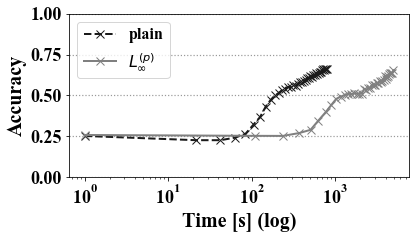

,round,accuracy_u,rel_time_u,cumtime_u,accuracy_l8p,rel_time_l8p,cumtime_l8p
0,1,0.2524,1.000,1.000,0.2583,1.000,1.000
1,2,0.2265,20.327,21.327,0.2530,109.685,110.685
2,3,0.2264,20.928,42.255,0.2526,125.944,236.629
3,4,0.2421,20.982,63.237,0.2704,135.476,372.105
4,5,0.2654,20.977,84.214,0.2897,133.556,505.661
5,6,0.3222,20.944,105.158,0.3465,122.032,627.693
6,7,0.3686,20.959,126.117,0.3979,139.716,767.409
7,8,0.4322,20.994,147.111,0.4425,130.580,897.989
8,9,0.4720,20.969,168.080,0.4790,128.009,1025.998
9,10,0.4996,20.929,189.009,0.4930,135.855,1161.853


In [8]:
from plots.e2e_time import build_fig_e2e_cifar_time
from functools import reduce

df_u = _preprocess(_select_df(observer_data, "CIFAR Large plain None"), "u")
df_l8p = _preprocess(_select_df(observer_data, "CIFAR Large linf_opt optimized"), "l8p")

data_frames = [df_u, df_l8p]
df = reduce(lambda  left, right: pd.merge(left, right, on=['round'], how='outer'), data_frames)
fig_e2e_cifar_time = build_fig_e2e_cifar_time(df)
display(fig_e2e_cifar_time)

display(df)

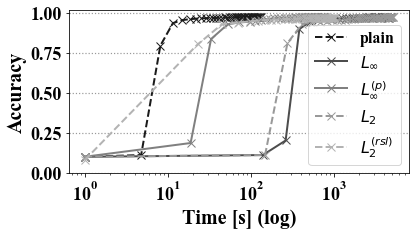

,round,accuracy_u,rel_time_u,cumtime_u,accuracy_l8,rel_time_l8,cumtime_l8,accuracy_l8p,rel_time_l8p,cumtime_l8p,accuracy_l2,rel_time_l2,cumtime_l2,accuracy_l2rst,rel_time_l2rst,cumtime_l2rst
0,0,0.1027,1.000,1.000,0.1027,1.000,1.000,0.1027,1.000,1.000,0.1027,1.000,1.000,0.0816,1.000,1.000
1,1,0.1135,3.777,4.777,0.1135,137.772,138.772,0.1886,17.793,18.793,0.1135,146.385,147.385,0.8035,21.768,22.768
2,2,0.7964,3.361,8.138,0.2045,121.865,260.637,0.8376,14.301,33.094,0.8126,126.901,274.286,0.9282,21.598,44.366
3,3,0.9369,3.382,11.520,0.8999,120.699,381.336,0.9292,19.347,52.441,0.9313,137.411,411.697,0.9399,25.639,70.005
4,4,0.9553,3.382,14.902,0.9446,127.618,508.954,0.9412,20.083,72.524,0.9410,131.615,543.312,0.9487,26.221,96.226
5,5,0.9616,3.381,18.283,0.9548,122.384,631.338,0.9453,23.489,96.013,0.9453,127.798,671.110,0.9517,24.228,120.454
6,6,0.9642,3.368,21.651,0.9600,124.557,755.895,0.9528,15.054,111.067,0.9517,137.561,808.671,0.9568,28.748,149.202
7,7,0.9665,3.364,25.015,0.9634,132.217,888.112,0.9562,20.206,131.273,0.9538,128.864,937.535,0.9585,24.743,173.945
8,8,0.9677,3.365,28.380,0.9669,120.864,1008.976,0.9606,19.341,150.614,0.9550,135.558,1073.093,0.9589,26.958,200.903
9,9,0.9679,3.356,31.736,0.9651,122.225,1131.201,0.9643,19.654,170.268,0.9575,135.287,1208.380,0.9606,26.095,226.998


In [9]:
from plots.e2e_time import build_fig_e2e_mnist_time
from functools import reduce

df_u = _preprocess(_select_df(observer_data, "MNIST plain None"), "u")
# display(df_u)
# display(observer_data)
df_l8 = _preprocess(_select_df(observer_data, "MNIST linf unoptimized"), "l8")
df_l8p = _preprocess(_select_df(observer_data, "MNIST linf_opt optimized"), "l8p")
df_l2 = _preprocess(_select_df(observer_data, "MNIST l2 unoptimized"), "l2")
df_l2rst = _preprocess(_select_df(observer_data, "MNIST l2_opt optimized"), "l2rst")
#
data_frames = [df_u, df_l8, df_l8p, df_l2, df_l2rst]
df = reduce(lambda  left, right: pd.merge(left, right, on=['round'], how='outer'), data_frames)
fig_e2e_mnist_time = build_fig_e2e_mnist_time(df)
display(fig_e2e_mnist_time)

display(df)